# GGML on AnnData

How to improve OT applications on AnnData.

In [1]:
import ggml_ot
import scanpy as sc
import pandas as pd

This tutorial uses the Myocardial Infarction dataset from Kuppe et. al, 2022. You can use the provided interface to download it from [CELLxGENE](https://cellxgene.cziscience.com/collections/8191c283-0816-424b-9b61-c3e1d6258a77) or load your own AnnData file instead. We filter highly variable genes to speed up computations for the tutorial.

In [2]:
id = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
adata = ggml_ot.data.load_cellxgene(id)

sc.pp.highly_variable_genes(adata,n_top_genes=5000,subset=True)

## Setup dataset `from_anndata`

To perform Supervised Optimal Transport, we set up a `TripletDataset` object based on the AnnData. This requires two parameters that identify relevant `obs` in the AnnData: 
- `patient_col` the patient/sample identifier
- `label_col` the corresponding patient groups/class labels whose relation we want to capture. 

The following columns (`.obs`) in the Myocardial Infarction AnnData object contain the information for each cell to which patient it belongs (`patient_col`) and their corresponding disease state/label (`label_col`). 

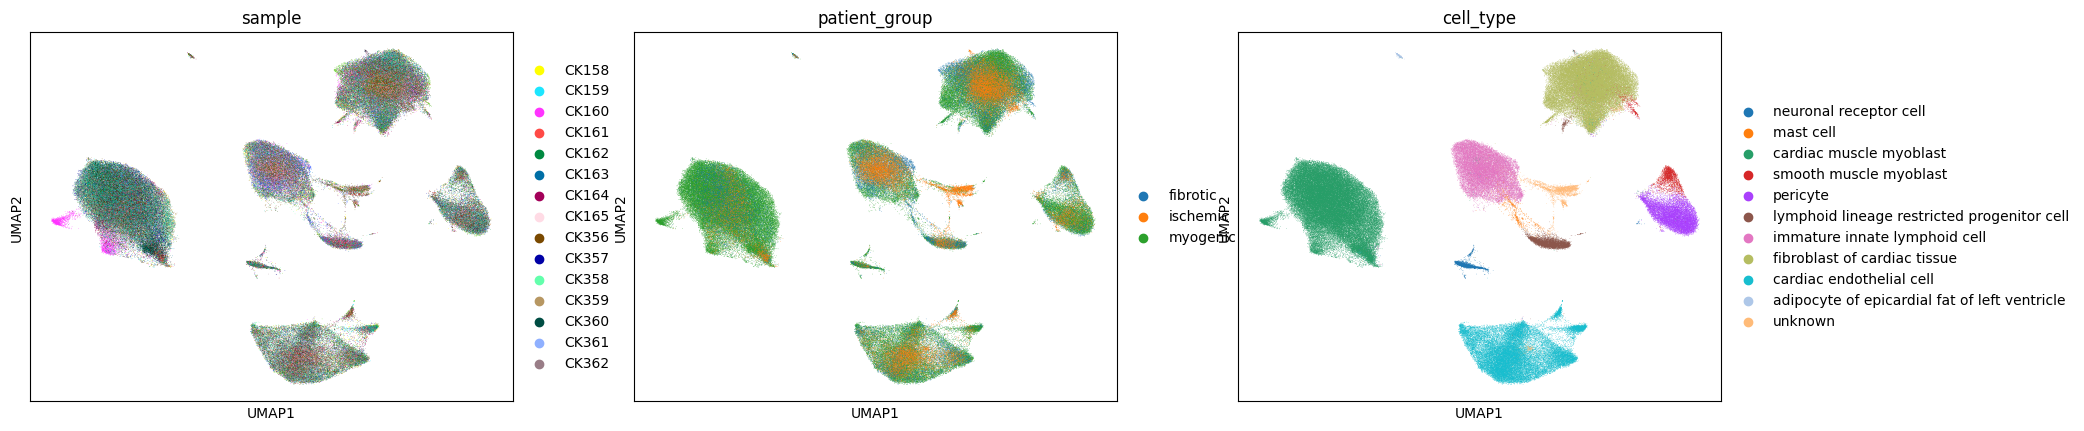

In [3]:
#Plot relevant .obs of Myocardial Infarction AnnData
sc.pl.umap(adata,color=["sample","patient_group","cell_type"])

#Setup dataset
dataset = ggml_ot.from_anndata(adata, patient_col="sample", label_col="patient_group") 

## Traditional OT on Single-cell data

A common analysis on single-cell data is to **investigate genetic differences between patient groups** like disease states. To capture these differences by Optimal Transport, each patient/sample is considered as a distribution of cells over the expressed genes. The cost of mapping the cells from two patient is then interpreted as a distance measure capturing their genetic differences.

To motivate Supervised Optimal Transport, we first compute the unsupervised OT distance between patients with the Euclidean distance and Cosine similarity as fixed ground metric. As an example application, we perform clustering and embedding of the patients.

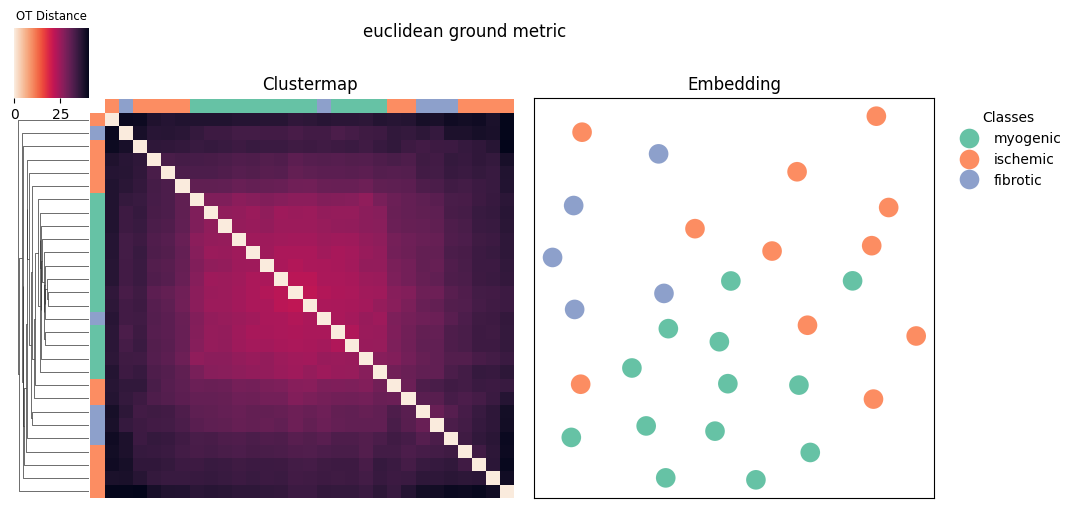

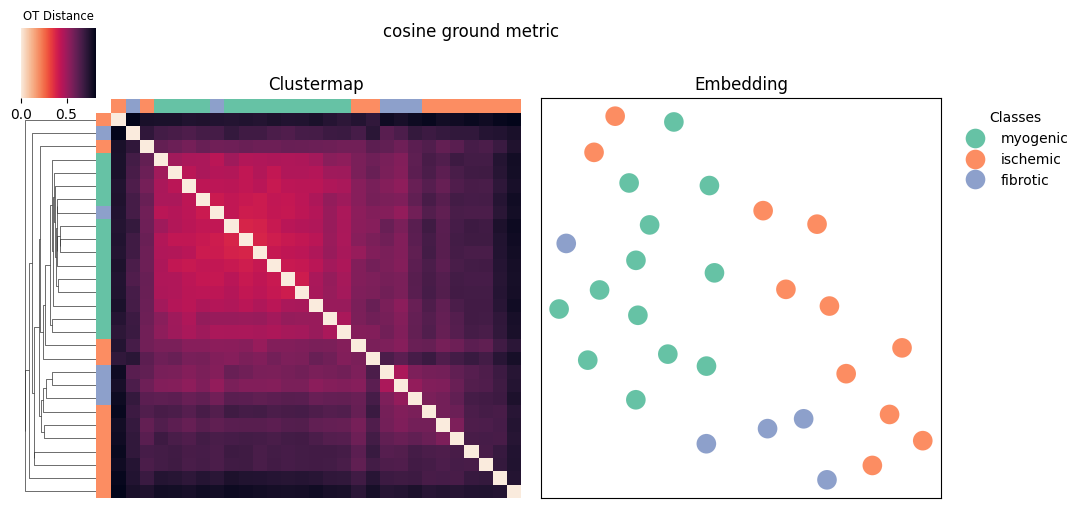

In [4]:
for gm in ["euclidean","cosine"]:
    _ = dataset.compute_OT(ground_metric=gm)

We can see that Optimal Transport captures some relation of the considered patient groups. However, unsupervised approaches cannot differentiate disease-related genetic differences from unrelated differences, such as noise, biological fluctuations and other biological processes.

## Supervised OT with GGML `train` 

**G**lobal **G**round **M**etric **L**earning (**GGML**) learns ground metrics that capture class relations between distributions under OT. On single-cell data, it learns to capture the relation between patients w.r.t their disease state and thus, differentiates disease-related genetic changes from noise.

Let's train such a ground metric on the TripletDataset that we setup from the Myocardial Infarction AnnData. 

*For information on the  **hyperparameters and how to tune them**  refer to the tutorial on [hyperparameter tuning](../tutorials/ggml_hyperparameter_tuning.html).*

Running GGML with alpha: 10, reg: 1, reg_type: 2, n_comps: 2


100%|██████████| 3/3 [00:30<00:00, 10.22s/it]


Iteration 1 with Loss  141.2117462158203


100%|██████████| 3/3 [00:18<00:00,  6.22s/it]


Iteration 2 with Loss  125.55571746826172


100%|██████████| 3/3 [00:18<00:00,  6.03s/it]


Iteration 3 with Loss  113.65460968017578


100%|██████████| 3/3 [00:18<00:00,  6.10s/it]


Iteration 4 with Loss  105.15351104736328


100%|██████████| 3/3 [00:18<00:00,  6.26s/it]


Iteration 5 with Loss  97.13188171386719
Compute all OT distances after 5 iterations


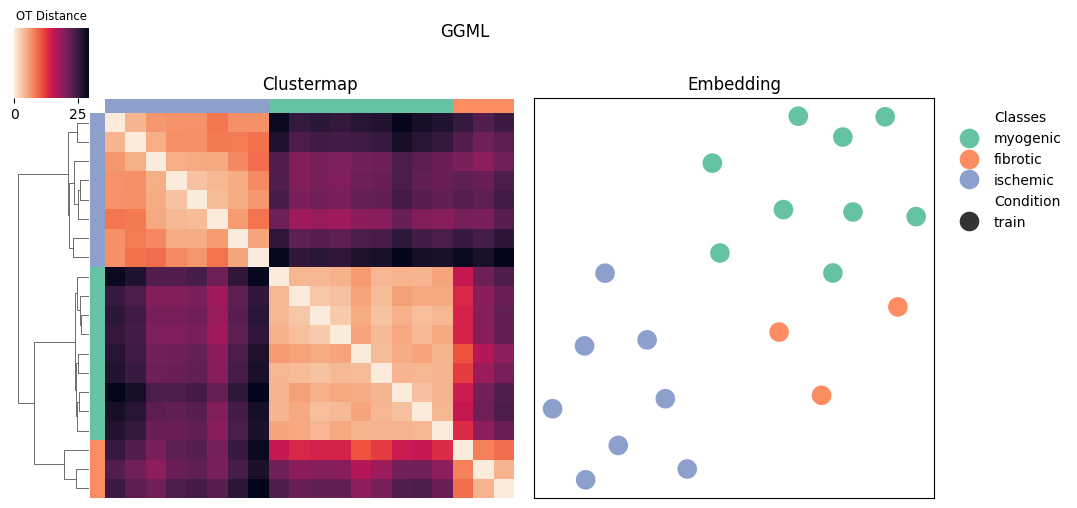

In [ ]:
dataset.train(
    alpha=10, reg=1, reg_type=2, n_comps=2, 
    train_size = 0.7, max_iter=5, verbose=True
)

By default, the train method returns the dataset with the AnnData object containing the learned ground metric. It is stored in the field `.varm["W_GGMLs"]`, or more specifically the components (or loadings) of the learned gene subspace. The embedding of the single cells in this gene subspace is stored in `.obsm["X_GGML"]`.

In [7]:
adata = dataset.adata
adata

AnnData object with n_obs × n_vars = 191795 × 5000
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_original_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_ver

The `.obsm["X_GGML"]` can be plotted with scanpy like other embeddings. 

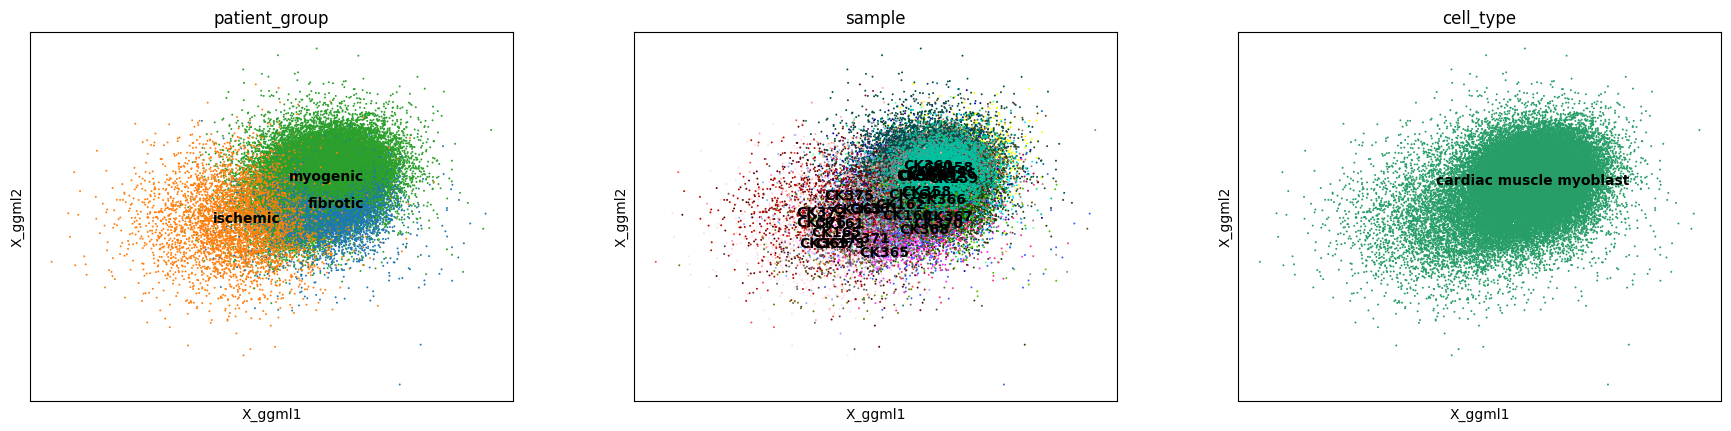

In [11]:
sc.pl.embedding(adata[adata.obs["cell_type"]=="cardiac muscle myoblast"],
                basis="X_ggml",color=["patient_group","sample","cell_type"],
                s=8,use_raw=False,legend_loc='on data')

*For more information on how to **analyze and interpret the learned gene subspace and embeddings** refer to the tutorial on [biological analysis of gene subspaces](../tutorials/ggml_biological_analysis.html).*

## Comparison of Ground Metrics

After training, we evaluate the learned ground metric on the corresponding test split with `test()` function. We compare it to the baseline of performing OT with the Euclidean distance and Cosine similarity as ground metric. 

*Note: Using the Euclidean and Cosine distance can be slow for high-dimensional data. You do not need to compute this step to train GGML on your data.*

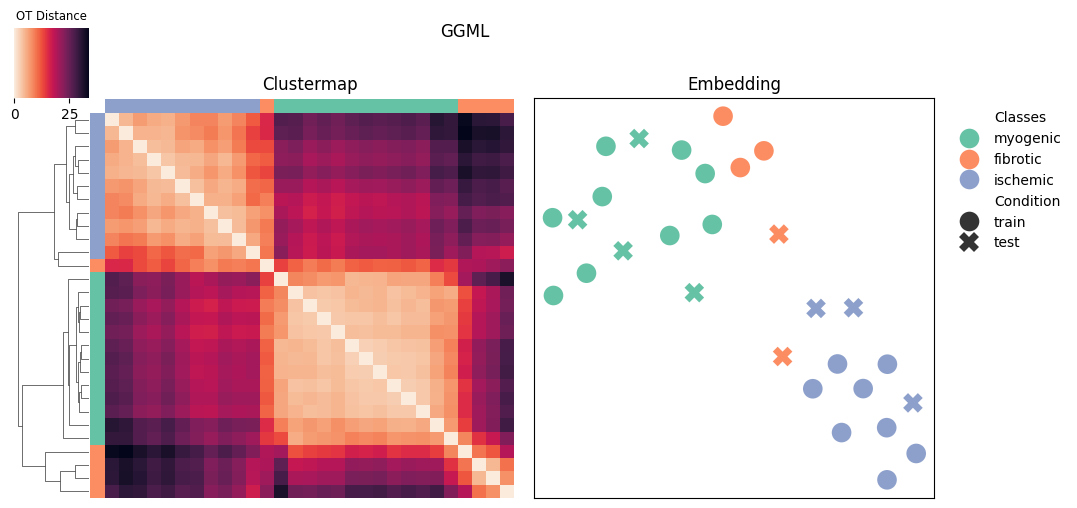

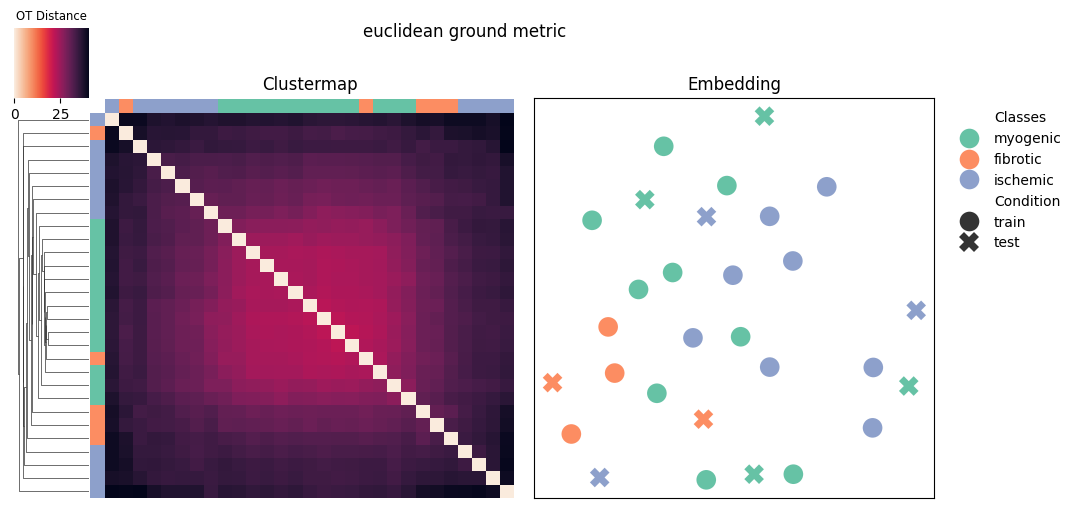

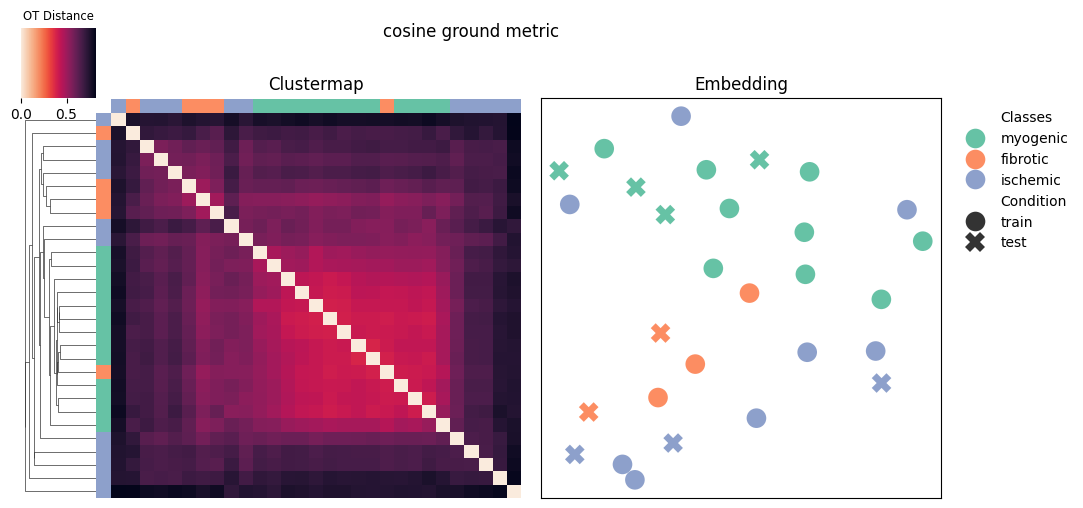

In [ ]:
scores = {}
ground_metrics = {
    "GGML":dataset.w_theta,
    "Euclidean":"euclidean",
    "Cosine":"cosine"
}

for name, metric in ground_metrics.items():
    scores[name] = dataset.test(
        ground_metric=metric, n_splits=1, test_size = 0.3, 
        print_table=False, return_dataset = False
    )    

scores_df = pd.concat([scores[metric] for metric in scores], ignore_index=True)
ggml_ot.pl.table(scores_df.set_index(pd.Index(scores.keys(),name="Ground Metric")))